In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label, filter_df_by_label
from lr.text_processing.transformations.wordnet import path_base_transformation

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Loading data

In [2]:
train_path = "data/snli/train.csv"
dev_path = "data/snli/dev.csv"

train_path_mod = "data/snli/train_p_h_syn_noun.csv"
dev_path_mod = "data/snli/dev_p_h_syn_noun.csv"

train_trans = lambda df: path_base_transformation(df, train_path_mod)
dev_trans = lambda df: path_base_transformation(df, dev_path_mod)


train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
train = filter_df_by_label(train.dropna()).reset_index(drop=True)
dev = filter_df_by_label(dev.dropna()).reset_index(drop=True)

train = train.head(10000)
dev = dev.head(1000)

dev_t = dev_trans(dev)

pre_process_nli_df(train)
pre_process_nli_df(dev)

print(train.shape)
print(dev.shape)

(10000, 3)
(1000, 3)


### Params

In [3]:
from lr.training.language_representation import Tfidf
from lr.training.util import get_ternary_label

max_features = None

param_grid = {"C": np.linspace(0, 3, 50),
              "penalty":["l2"]}


hyperparams = {"RepresentationFunction": Tfidf,
               "cv":5,
               "solver": 'lbfgs',
               "random_state": None,
               "verbose":True,
               "n_jobs":1,
               "n_iter":2,
               "max_features": max_features,
               "label_translation": get_ternary_label,
               "param_grid": param_grid}

In [4]:
np.random.seed(1234)


## DGP

In [5]:
from lr.stats.h_testing import DGP

M = 1

dgp = DGP(train, train_trans, rho=0.3)

train_ = dgp.sample()

## Train different models on the same sample

In [6]:
from lr.models.logistic_regression import LRWrapper

E = 2


models = []

for e in range(E):
    lr = LRWrapper(hyperparams)
    lr.fit(train_)
    models.append(lr)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.7s finished


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.3s finished


### Get majority vote

In [7]:
from lr.stats.h_testing import  Majority


accs = [lr.get_acc(train_) for lr in models]
lr = Majority(models)

print("mean acc = {:.3f} | std = {:.3f}".format(np.mean(accs), np.std(accs)))
print("majority vote acc = {:.5f}".format(lr.get_acc(train_)))


mean acc = 0.696 | std = 0.009
majority vote acc = 0.69730


### Get t statistic using majority model and dev data

In [8]:
from lr.stats.h_testing import  get_matched_results, get_paired_t_statistic

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-0.22299378798752204


-0.22299378798752204

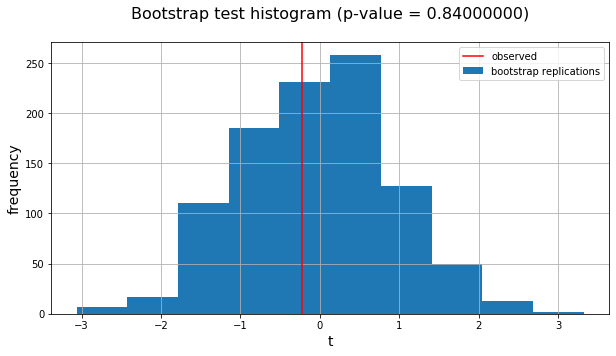

In [9]:
from lr.stats.h_testing import get_boot_sample_under_H0
from lr.stats.h_testing import get_boot_p_value


S = 1000

t_boots = []

for _ in range(S):
    boot_sample_result = get_boot_sample_under_H0(results)
    boot_t = get_paired_t_statistic(boot_sample_result)
    t_boots.append(boot_t)
    
t_boots = pd.Series(t_boots)

p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

0.84